In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [2]:
Train_data_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
!tar -xf /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar -C /kaggle/working/

In [3]:
!pip install nibabel

In [4]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"


BASE = "/kaggle/working"
BATCH_SIZE = 8
EPOCHS = 3
LR = 1e-4
NUM_CLASSES = 4


# 7 slices: 1/4, 3/8, 7/16, 1/2, 9/16, 5/8, 3/4
SLICE_RATIOS_7 = [0.25, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.75]


In [5]:
DATA_DIR = "/kaggle/working"

patients = sorted(
    [p for p in glob(os.path.join(DATA_DIR, "BraTS2021_*")) if os.path.isdir(p)]
)

print("Nombre total de patients :", len(patients))


Nombre total de patients : 1251


In [6]:
def normalize(volume):
    volume = volume.astype(np.float32)
    if volume.max() > volume.min():
        volume = (volume - volume.min()) / (volume.max() - volume.min())
    return volume


def get_slices(volume, ratios):
    z = volume.shape[2]
    indices = [int(r * (z - 1)) for r in ratios]
    return volume[:, :, indices]


In [7]:
class BraTSDataset(Dataset):
    def __init__(self, patient_dirs):
        self.patient_dirs = patient_dirs
        self.modalities = ["flair", "t1", "t1ce", "t2"]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p = self.patient_dirs[idx]

        imgs = []
        for m in self.modalities:
            path = glob(os.path.join(p, f"*_{m}.nii.gz"))[0]
            vol = nib.load(path).get_fdata()
            vol = normalize(vol)
            slices = get_slices(vol, SLICE_RATIOS_7)
            imgs.append(slices)

        # shape: (H, W, 7, 4)
        X = np.stack(imgs, axis=-1)
        X = np.transpose(X, (2, 3, 0, 1))  # (7, 4, H, W)
        X = X.reshape(7 * 4, X.shape[2], X.shape[3])

        seg_path = glob(os.path.join(p, "*_seg.nii.gz"))[0]
        seg = nib.load(seg_path).get_fdata()
        seg = seg.astype(np.int64)

        seg[seg == 4] = 3

        z_mid = seg.shape[2] // 2
        Y = seg[:, :, z_mid]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)


In [8]:
train_p, temp_p = train_test_split(patients, test_size=0.3, random_state=42)
val_p, test_p = train_test_split(temp_p, test_size=0.5, random_state=42)

train_ds = BraTSDataset(train_p)
val_ds   = BraTSDataset(val_p)
test_ds  = BraTSDataset(test_p)


In [9]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)


In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(28, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.dec3 = DoubleConv(256 + 128, 128)
        self.dec2 = DoubleConv(128 + 64, 64)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.out = nn.Conv2d(64, NUM_CLASSES, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d3 = self.up(e3)
        d3 = self.dec3(torch.cat([d3, e2], dim=1))

        d2 = self.up(d3)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        return self.out(d2)


In [12]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets, NUM_CLASSES).permute(0,3,1,2)

        dims = (0,2,3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot, dims)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
        
weights = torch.tensor([0.1, 0.3, 0.3, 0.3]).to(device)

ce_loss = nn.CrossEntropyLoss(weight=weights)
dice_loss = DiceLoss()

def combined_loss(pred, target):
    return ce_loss(pred, target) + dice_loss(pred, target)


In [13]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = combined_loss(pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1} | Train loss: {train_loss/len(train_loader):.4f}")


Epoch 1 | Train loss: 1.5996
Epoch 2 | Train loss: 1.2673
Epoch 3 | Train loss: 1.0972


In [14]:
def dice_brats(pred, target, eps=1e-5):
    pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    WT = ((pred > 0) & (target > 0)).float()
    TC = (((pred == 1) | (pred == 3)) & ((target == 1) | (target == 3))).float()
    ET = ((pred == 3) & (target == 3)).float()

    def dice(a, b):
        return (2*(a*b).sum() + eps) / (a.sum() + b.sum() + eps)

    return {
        "WT": dice(WT, target > 0).item(),
        "TC": dice(TC, (target == 1) | (target == 3)).item(),
        "ET": dice(ET, target == 3).item()
    }


In [15]:
model.eval()

dice_WT = []
dice_TC = []
dice_ET = []

with torch.no_grad():
    for X, Y in test_loader:

        # Gestion batch_size = 1
        if X.dim() == 4:
            X = X.unsqueeze(0)
            Y = Y.unsqueeze(0)

        B, S, M, H, W = X.shape
        X = X.view(B, S * M, H, W).to(device)

        Y = Y.to(device)
        Y = Y.squeeze(1)   # (B, H, W)

        pred = model(X)

        scores = dice_brats(pred, Y)

        dice_WT.append(scores["WT"])
        dice_TC.append(scores["TC"])
        dice_ET.append(scores["ET"])

print(f"Dice WT moyen : {np.mean(dice_WT):.4f}")
print(f"Dice TC moyen : {np.mean(dice_TC):.4f}")
print(f"Dice ET moyen : {np.mean(dice_ET):.4f}")


Dice WT moyen : 0.9052
Dice TC moyen : 0.8135
Dice ET moyen : 0.8577


TypeError: Invalid shape (1, 240, 240) for image data

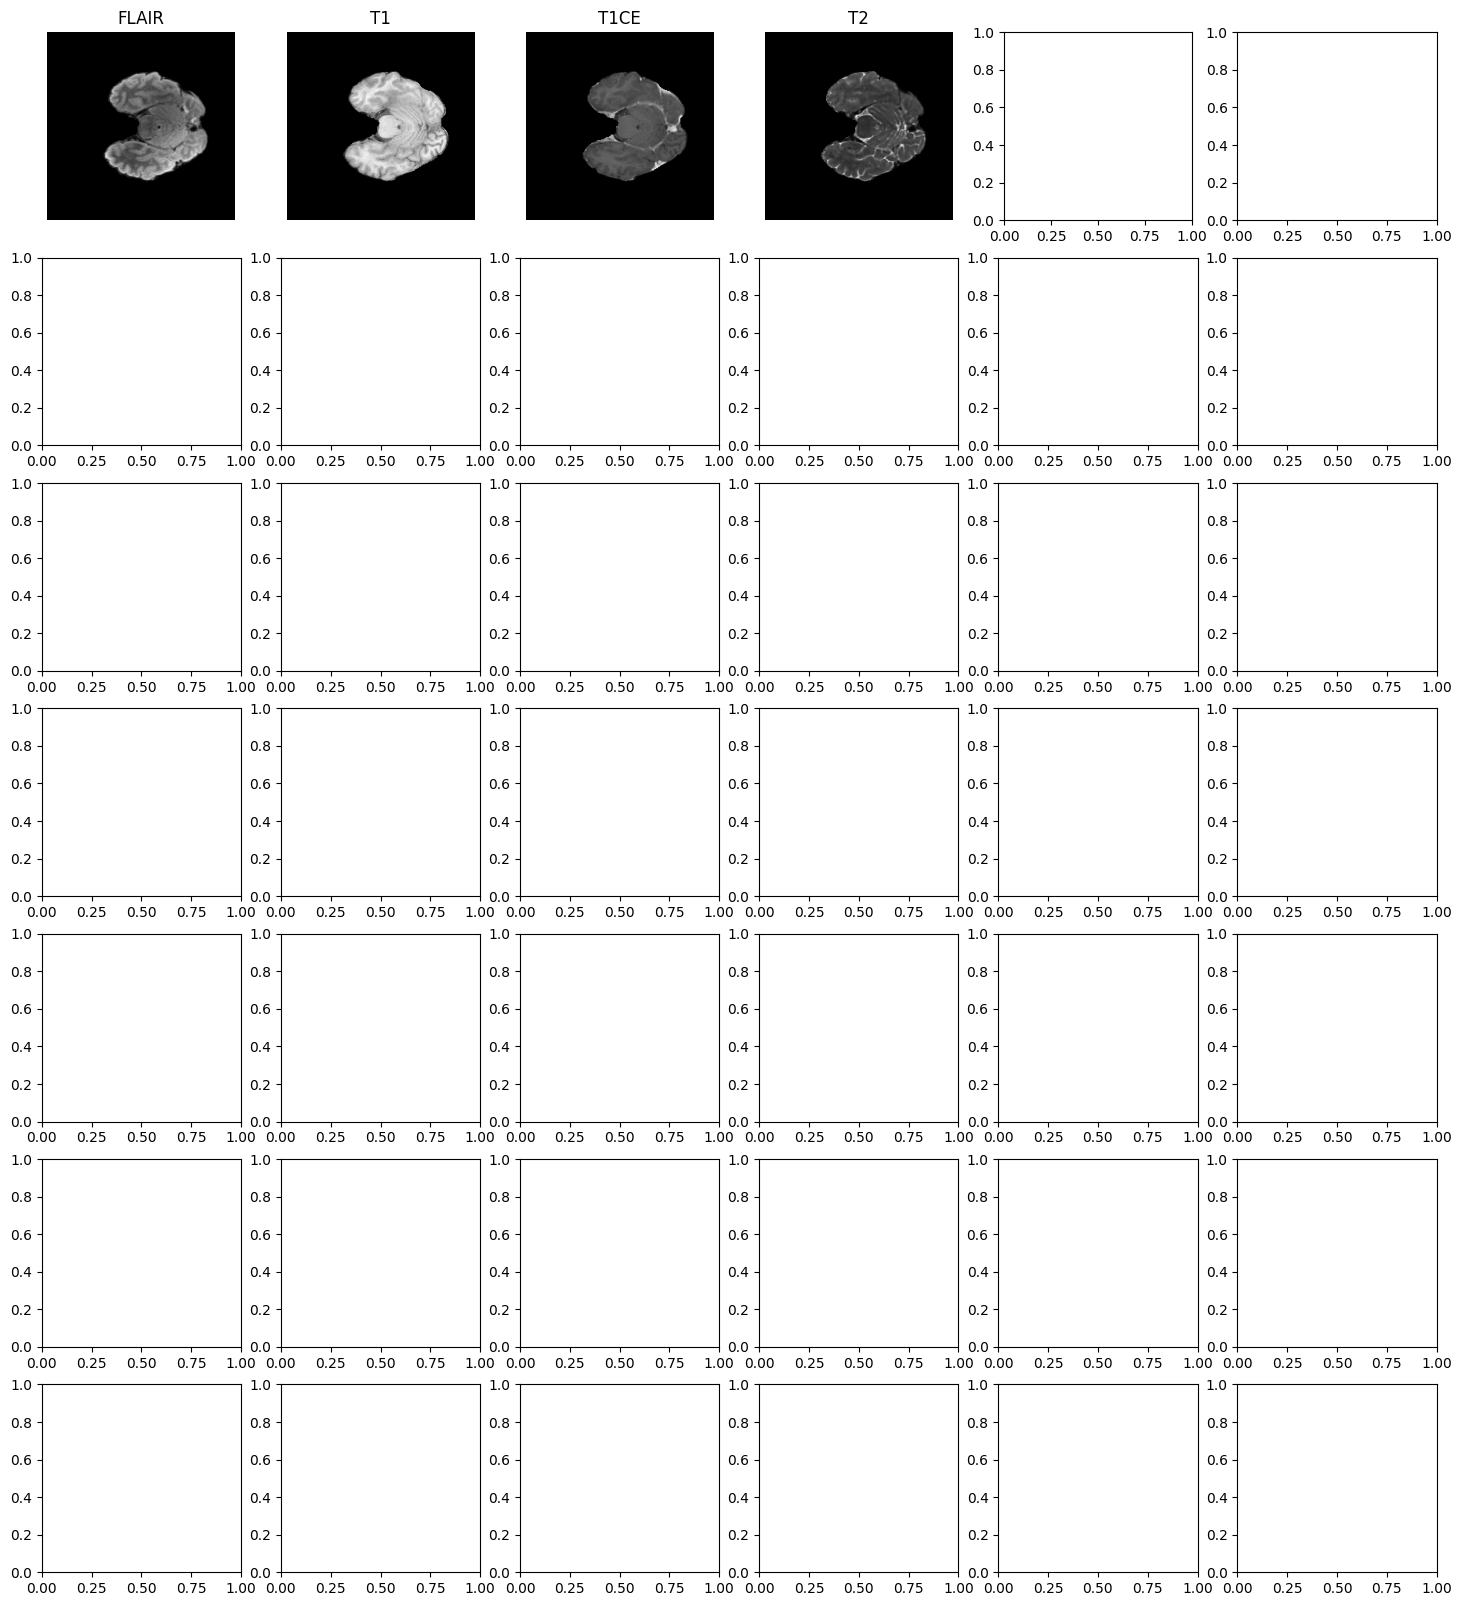

In [16]:
X, Y = next(iter(test_loader))

if X.dim() == 4:
    X = X.unsqueeze(0)
    Y = Y.unsqueeze(0)

B, S, M, H, W = X.shape

X_in = X.view(B, S * M, H, W).to(device)

with torch.no_grad():
    pred = model(X_in).argmax(1)[0].cpu()

fig, axes = plt.subplots(7, 6, figsize=(18, 20))

for i in range(7):
    for m in range(4):
        axes[i, m].imshow(X[0, i, m], cmap="gray")
        axes[i, m].axis("off")
        if i == 0:
            axes[i, m].set_title(["FLAIR", "T1", "T1CE", "T2"][m])

    axes[i, 4].imshow(Y[0], cmap="jet", vmin=0, vmax=3)
    axes[i, 4].axis("off")
    if i == 0:
        axes[i, 4].set_title("GT")

    axes[i, 5].imshow(pred, cmap="jet", vmin=0, vmax=3)
    axes[i, 5].axis("off")
    if i == 0:
        axes[i, 5].set_title("Pred")

plt.tight_layout()
plt.show()